# Frequentist Models

This notebook evaluates the performance of some frequentist models for wealth. We ignore time effects / exogenous regressors. The tested distributions are:
- Pareto
- Weibull
- Generalised Pareto

### Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Self-made modules
from thesis_tools.utils.data import *
from thesis_tools.models.frequentist import *
from thesis_tools.statistical_tests.tests import *

## Estimation

In [3]:
df = read_billionaires_data()
years = df['year'].unique()
sub_regions = df['sub_region'].unique()
sub_regions = sub_regions[sub_regions != 'Not a sub-region']

In [4]:
parameter_estimates = {}
for year in years:
    for sub_region in sub_regions:
        billionaires = df[(df['year'] == year) & (df['sub_region'] == sub_region)]
        n_billionaires = len(billionaires)
        if n_billionaires <= 64:
            continue
        mean_wealth = billionaires['net_worth'].mean()
        mean_log_wealth = billionaires['log_net_worth'].mean()
        data = billionaires['net_worth']
        
        # Estimate a Pareto
        pareto = Pareto()
        alpha_pareto, _ = pareto.fit(data=data)
        
        # Estimate a Weibull
        weibull = Weibull()
        gamma_weibull, alpha_weibull = weibull.fit(data=data)

        # Estimate a Generalised Pareto
        generalised_pareto = GeneralisedPareto()
        gamma_generalised_pareto_MLE, sigma_generalised_pareto_MLE, _ = generalised_pareto.fit(data=data)
        gamma_generalised_pareto_Hill, sigma_generalised_pareto_Hill, _ = generalised_pareto.fit_hill(data=data)

        parameter_estimates[(year, sub_region)] = {
            'n_billionaires': n_billionaires,
            'mean_wealth': mean_wealth,
            'mean_log_wealth': mean_log_wealth,
            'alpha_pareto': alpha_pareto,
            'gamma_weibull': gamma_weibull,
            'alpha_weibull': alpha_weibull,
            'gamma_generalised_pareto_MLE': gamma_generalised_pareto_MLE,
            'sigma_generalised_pareto_MLE': sigma_generalised_pareto_MLE,
            'gamma_generalised_pareto_Hill': gamma_generalised_pareto_Hill,
            'sigma_generalised_pareto_Hill': sigma_generalised_pareto_Hill
        }
        
parameter_estimates_df = pd.DataFrame(parameter_estimates).T

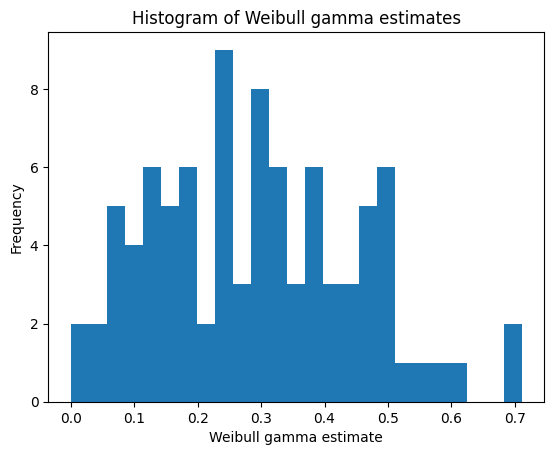

Mean Weibull gamma estimate: 0.2910396447637515
Median Weibull gamma estimate: 0.2919932068092991


In [5]:
# Histogram of the Weibull gamma estimates
plt.hist(parameter_estimates_df['gamma_weibull'], bins=25)
plt.xlabel('Weibull gamma estimate')
plt.ylabel('Frequency')
plt.title('Histogram of Weibull gamma estimates')
plt.show()
# Print the mean and median of the Weibull gamma estimates
mean_gamma_weibull = parameter_estimates_df['gamma_weibull'].mean()
median_gamma_weibull = parameter_estimates_df['gamma_weibull'].median()
print('Mean Weibull gamma estimate:', mean_gamma_weibull)
print('Median Weibull gamma estimate:', median_gamma_weibull)

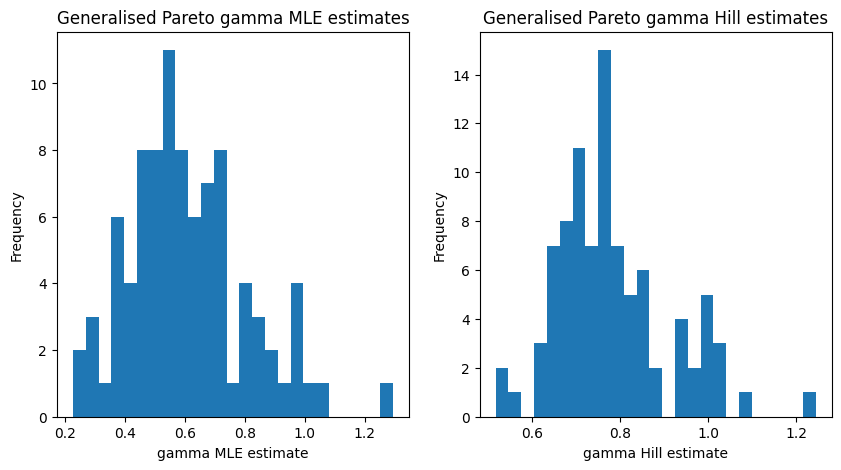

Mean Generalised Pareto gamma MLE estimate: 0.6087288498212761
Median Generalised Pareto gamma MLE estimate: 0.5720621126736547
Mean Generalised Pareto gamma Hill estimate: 0.7816969944863078
Median Generalised Pareto gamma Hill estimate: 0.7647940252412713


In [6]:
# In 2 histograms, plot the MLE and Hill gamma estimates of the Generalised Pareto
fix, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].hist(parameter_estimates_df['gamma_generalised_pareto_MLE'], bins=25)
ax[0].set_xlabel('gamma MLE estimate')
ax[0].set_ylabel('Frequency')
ax[0].set_title('Generalised Pareto gamma MLE estimates')
ax[1].hist(parameter_estimates_df['gamma_generalised_pareto_Hill'], bins=25)
ax[1].set_xlabel('gamma Hill estimate')
ax[1].set_ylabel('Frequency')
ax[1].set_title('Generalised Pareto gamma Hill estimates')
plt.show()
# Print the mean and median of the Generalised Pareto gamma estimates
mean_gamma_generalised_pareto_MLE = parameter_estimates_df['gamma_generalised_pareto_MLE'].mean()
median_gamma_generalised_pareto_MLE = parameter_estimates_df['gamma_generalised_pareto_MLE'].median()
mean_gamma_generalised_pareto_Hill = parameter_estimates_df['gamma_generalised_pareto_Hill'].mean()
median_gamma_generalised_pareto_Hill = parameter_estimates_df['gamma_generalised_pareto_Hill'].median()
print('Mean Generalised Pareto gamma MLE estimate:', mean_gamma_generalised_pareto_MLE)
print('Median Generalised Pareto gamma MLE estimate:', median_gamma_generalised_pareto_MLE)
print('Mean Generalised Pareto gamma Hill estimate:', mean_gamma_generalised_pareto_Hill)
print('Median Generalised Pareto gamma Hill estimate:', median_gamma_generalised_pareto_Hill)


The following can be concluded from the initial estimation:

- For Weibull, it is quite easy to choose a single gamma parameter across all samples
- In general, it seems more convenient to choose the median MLE estimate for the GPD
- The Hill estimates are generally higher than the MLE estimates
- Problem with Hill estimates - requires human judgement for the Hill plot

We now re-estimate the scale parameters only for all sub-region / year pairs, with fixed pre-determined shape parameters.

In [7]:
pre_determined_Weibull_gamma = median_gamma_weibull
pre_determined_GeneralisedPareto_gamma = median_gamma_generalised_pareto_MLE

In [8]:
parameter_estimates = {}
for year in years:
    for sub_region in sub_regions:
        billionaires = df[(df['year'] == year) & (df['sub_region'] == sub_region)]
        n_billionaires = len(billionaires)
        if n_billionaires <= 64:
            continue
        mean_wealth = billionaires['net_worth'].mean()
        mean_log_wealth = billionaires['log_net_worth'].mean()
        data = billionaires['net_worth']
        
        # Estimate a Pareto
        pareto = Pareto()
        alpha_pareto, _ = pareto.fit(data=data)
        
        # Estimate a Weibull
        weibull = Weibull()
        gamma_weibull, alpha_weibull = weibull.fit(
            data=data, 
            given_gamma=pre_determined_Weibull_gamma
        )

        # Estimate a Generalised Pareto
        generalised_pareto = GeneralisedPareto()
        gamma_generalised_pareto, sigma_generalised_pareto, _ = generalised_pareto.fit(
            data=data, 
            given_gamma=pre_determined_GeneralisedPareto_gamma
        )

        parameter_estimates[(year, sub_region)] = {
            'n_billionaires': n_billionaires,
            'mean_wealth': mean_wealth,
            'mean_log_wealth': mean_log_wealth,
            'alpha_pareto': alpha_pareto,
            'gamma_weibull': gamma_weibull,
            'alpha_weibull': alpha_weibull,
            'gamma_generalised_pareto': gamma_generalised_pareto,
            'sigma_generalised_pareto': sigma_generalised_pareto
        }
        
parameter_estimates_df = pd.DataFrame(parameter_estimates).T

Gamma parameter set to: None using given_gamma to estimate alpha using Teulings & Toussaint (2023).
Gamma parameter set to: 0.5720621126736547 using given_gamma.
Gamma parameter set to: None using given_gamma to estimate alpha using Teulings & Toussaint (2023).
Gamma parameter set to: 0.5720621126736547 using given_gamma.
Gamma parameter set to: None using given_gamma to estimate alpha using Teulings & Toussaint (2023).
Gamma parameter set to: 0.5720621126736547 using given_gamma.
Gamma parameter set to: None using given_gamma to estimate alpha using Teulings & Toussaint (2023).
Gamma parameter set to: 0.5720621126736547 using given_gamma.
Gamma parameter set to: None using given_gamma to estimate alpha using Teulings & Toussaint (2023).
Gamma parameter set to: 0.5720621126736547 using given_gamma.
Gamma parameter set to: None using given_gamma to estimate alpha using Teulings & Toussaint (2023).
Gamma parameter set to: 0.5720621126736547 using given_gamma.
Gamma parameter set to: None

## Evaluation

### Distribution fit

In [9]:
test_statistics = {}
for ind in parameter_estimates_df.index:
    print(ind)
    info = parameter_estimates_df.loc[ind]
    year, sub_region = ind
    billionaires = df[(df['year'] == year) & (df['sub_region'] == sub_region)]
    data = billionaires['net_worth']

    # Perform the Kolmogorov-Smirnov test
    # Pareto
    pareto = Pareto(alpha=info['alpha_pareto'])
    ks_pareto = Kolmogorov_Smirnov_H_0_test(
        data=data,
        H_0_distribution=pareto 
    )
    # Weibull
    weibull = Weibull(gamma=info['gamma_weibull'], alpha=info['alpha_weibull'])
    ks_weibull = Kolmogorov_Smirnov_H_0_test(
        data=data,
        H_0_distribution=weibull
    )
    # Generalised Pareto
    generalised_pareto = GeneralisedPareto(gamma=info['gamma_generalised_pareto'], sigma=info['sigma_generalised_pareto'])
    ks_generalised_pareto = Kolmogorov_Smirnov_H_0_test(
        data=data,
        H_0_distribution=generalised_pareto
    )

    # Perform the Cramer-von Mises test
    # Pareto
    cm_pareto = Anderson_Darling_H_0_test(
        data=data,
        H_0_distribution=pareto,
        weight_function='Cramer-von Mises'
    )
    # Weibull
    cm_weibull = Anderson_Darling_H_0_test(
        data=data,
        H_0_distribution=weibull,
        weight_function='Cramer-von Mises'
    )
    # Generalised Pareto
    cm_generalised_pareto = Anderson_Darling_H_0_test(
        data=data,
        H_0_distribution=generalised_pareto,
        weight_function='Cramer-von Mises'
    )

    # Perform the Anderson-Darling test
    # Pareto
    ad_pareto = Anderson_Darling_H_0_test(
        data=data,
        H_0_distribution=pareto,
        weight_function='Anderson-Darling'
    )
    # Weibull
    ad_weibull = Anderson_Darling_H_0_test(
        data=data,
        H_0_distribution=weibull,
        weight_function='Anderson-Darling'
    )
    # Generalised Pareto
    ad_generalised_pareto = Anderson_Darling_H_0_test(
        data=data,
        H_0_distribution=generalised_pareto,
        weight_function='Anderson-Darling'
    )

    test_statistics[ind] = {
        'ks_pareto_stat': ks_pareto[0],
        'ks_pareto_p_value': ks_pareto[1],
        'ks_weibull_stat': ks_weibull[0],
        'ks_weibull_p_value': ks_weibull[1],
        'ks_generalised_pareto_stat': ks_generalised_pareto[0],
        'ks_generalised_pareto_p_value': ks_generalised_pareto[1],
        'cm_pareto_stat': cm_pareto[1],
        'cm_pareto_p_value': cm_pareto[2],
        'cm_weibull_stat': cm_weibull[1],
        'cm_weibull_p_value': cm_weibull[2],
        'cm_generalised_pareto_stat': cm_generalised_pareto[1],
        'cm_generalised_pareto_p_value': cm_generalised_pareto[2],
        'ad_pareto_stat': ad_pareto[1],
        'ad_pareto_p_value': ad_pareto[2],
        'ad_weibull_stat': ad_weibull[1],
        'ad_weibull_p_value': ad_weibull[2],
        'ad_generalised_pareto_stat': ad_generalised_pareto[1],
        'ad_generalised_pareto_p_value': ad_generalised_pareto[2]
    }
test_statistics_df = pd.DataFrame(test_statistics).T

(Timestamp('2001-01-01 00:00:00'), 'U.S.')
(Timestamp('2002-01-01 00:00:00'), 'U.S.')
(Timestamp('2003-01-01 00:00:00'), 'U.S.')
(Timestamp('2004-01-01 00:00:00'), 'U.S.')
(Timestamp('2005-01-01 00:00:00'), 'U.S.')
(Timestamp('2006-01-01 00:00:00'), 'U.S.')
(Timestamp('2007-01-01 00:00:00'), 'U.S.')
(Timestamp('2008-01-01 00:00:00'), 'U.S.')
(Timestamp('2008-01-01 00:00:00'), 'Russia')
(Timestamp('2009-01-01 00:00:00'), 'U.S.')
(Timestamp('2010-01-01 00:00:00'), 'China')
(Timestamp('2010-01-01 00:00:00'), 'U.S.')
(Timestamp('2011-01-01 00:00:00'), 'China')
(Timestamp('2011-01-01 00:00:00'), 'U.S.')
(Timestamp('2011-01-01 00:00:00'), 'Russia')
(Timestamp('2012-01-01 00:00:00'), 'China')
(Timestamp('2012-01-01 00:00:00'), 'U.S.')
(Timestamp('2012-01-01 00:00:00'), 'Russia')
(Timestamp('2013-01-01 00:00:00'), 'China')
(Timestamp('2013-01-01 00:00:00'), 'U.S.')
(Timestamp('2013-01-01 00:00:00'), 'Russia')
(Timestamp('2014-01-01 00:00:00'), 'Germany')
(Timestamp('2014-01-01 00:00:00'), 'Bra

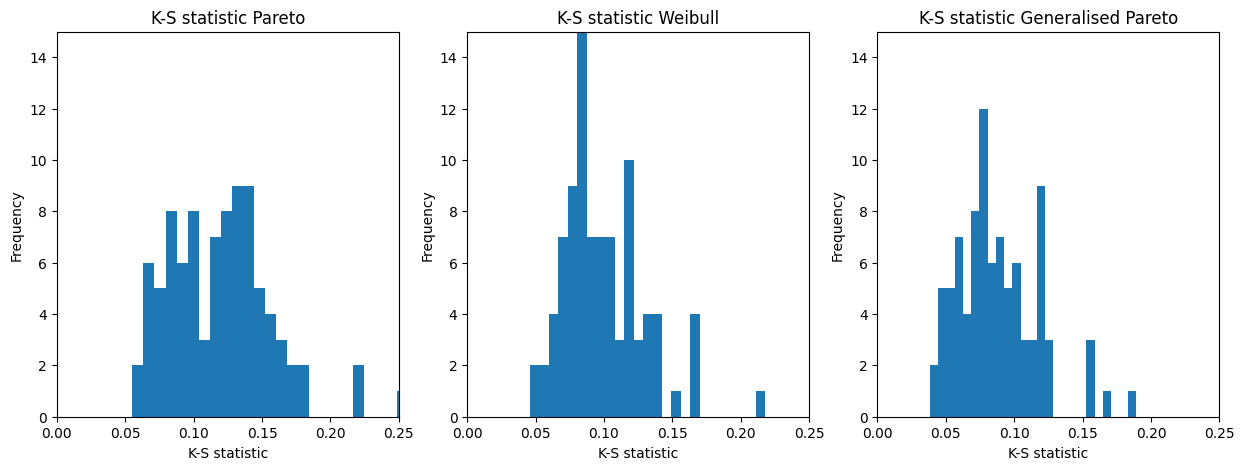

In [21]:
# Plot the K-S stats for the 3 distributions next to each other
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
x_lb, x_ub = 0.00, 0.25
y_lb, y_ub = 0, 15
n_bins = 25
ax[0].hist(test_statistics_df['ks_pareto_stat'], bins=n_bins)
ax[0].set_xlim(x_lb, x_ub)
ax[0].set_ylim(y_lb, y_ub)
ax[0].set_xlabel('K-S statistic')
ax[0].set_ylabel('Frequency')
ax[0].set_title('K-S statistic Pareto')
ax[1].hist(test_statistics_df['ks_weibull_stat'], bins=n_bins)
ax[1].set_xlim(x_lb, x_ub)
ax[1].set_ylim(y_lb, y_ub)
ax[1].set_xlabel('K-S statistic')
ax[1].set_ylabel('Frequency')
ax[1].set_title('K-S statistic Weibull')
ax[2].hist(test_statistics_df['ks_generalised_pareto_stat'], bins=n_bins)
ax[2].set_xlim(x_lb, x_ub)
ax[2].set_ylim(y_lb, y_ub)
ax[2].set_xlabel('K-S statistic')
ax[2].set_ylabel('Frequency')
ax[2].set_title('K-S statistic Generalised Pareto')
plt.show()


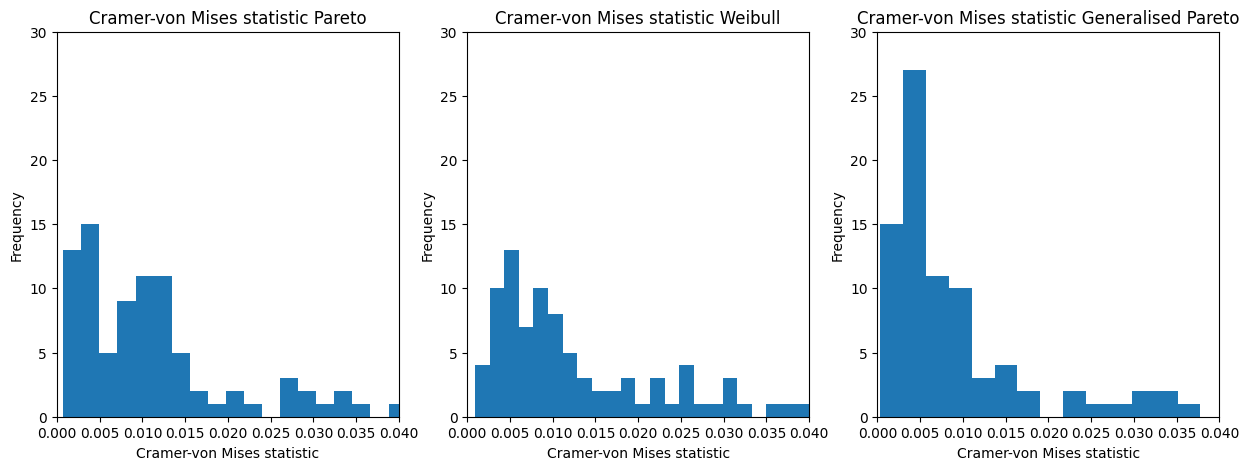

In [20]:
# Plot the Cramer-von Mises stats for the 3 distributions next to each other
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
x_lb, x_ub = 0.00, 0.04
y_lb, y_ub = 0, 30
n_bins = 40
ax[0].hist(test_statistics_df['cm_pareto_stat'], bins=n_bins)
ax[0].set_xlim(x_lb, x_ub)
ax[0].set_ylim(y_lb, y_ub)
ax[0].set_xlabel('Cramer-von Mises statistic')
ax[0].set_ylabel('Frequency')
ax[0].set_title('Cramer-von Mises statistic Pareto')
ax[1].hist(test_statistics_df['cm_weibull_stat'], bins=n_bins)
ax[1].set_xlim(x_lb, x_ub)
ax[1].set_ylim(y_lb, y_ub)
ax[1].set_xlabel('Cramer-von Mises statistic')
ax[1].set_ylabel('Frequency')
ax[1].set_title('Cramer-von Mises statistic Weibull')
ax[2].hist(test_statistics_df['cm_generalised_pareto_stat'], bins=n_bins)
ax[2].set_xlim(x_lb, x_ub)
ax[2].set_ylim(y_lb, y_ub)
ax[2].set_xlabel('Cramer-von Mises statistic')
ax[2].set_ylabel('Frequency')
ax[2].set_title('Cramer-von Mises statistic Generalised Pareto')
plt.show()


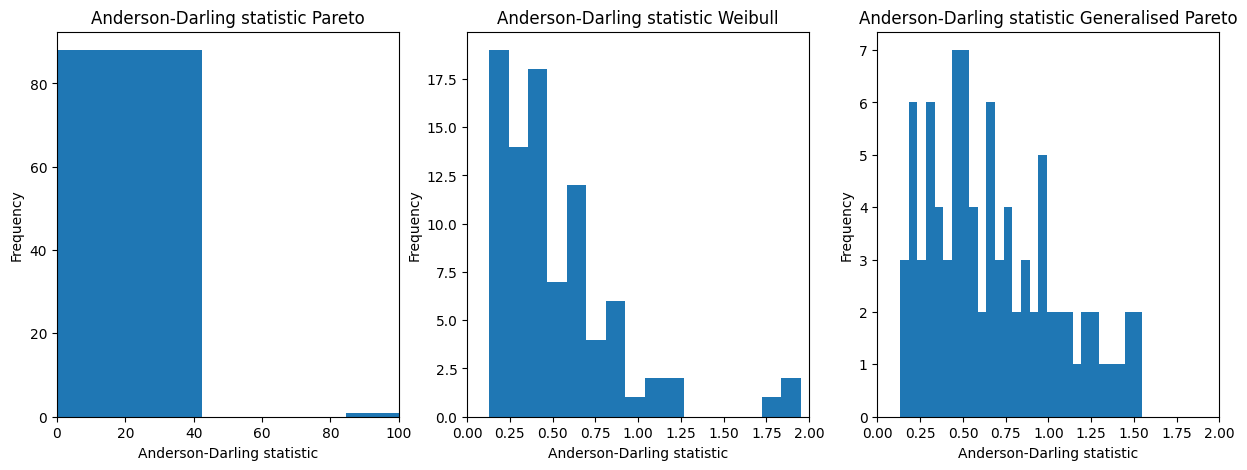

In [12]:
# Plot the Anderson-Darling stats for the 3 distributions next to each other
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
x_lb, x_ub = 0.00, 2.0
n_bins = 40
ax[0].hist(test_statistics_df['ad_pareto_stat'], bins=n_bins)
ax[0].set_xlim(0, 100)
ax[0].set_xlabel('Anderson-Darling statistic')
ax[0].set_ylabel('Frequency')
ax[0].set_title('Anderson-Darling statistic Pareto')
ax[1].hist(test_statistics_df['ad_weibull_stat'], bins=n_bins)
ax[1].set_xlim(x_lb, x_ub)
ax[1].set_xlabel('Anderson-Darling statistic')
ax[1].set_ylabel('Frequency')
ax[1].set_title('Anderson-Darling statistic Weibull')
ax[2].hist(test_statistics_df['ad_generalised_pareto_stat'], bins=n_bins)
ax[2].set_xlim(x_lb, x_ub)
ax[2].set_xlabel('Anderson-Darling statistic')
ax[2].set_ylabel('Frequency')
ax[2].set_title('Anderson-Darling statistic Generalised Pareto')
plt.show()


In [13]:
# Make a df to show how what proportion of p_values of the KS, CM and AD tests are below 0.10, 0.05, 0.01
p_value_counts = {}
for test in ['ks', 'cm', 'ad']:
    for dist in ['pareto', 'weibull', 'generalised_pareto']:
        for p_value in [0.10, 0.05, 0.01]:
            key = f'{test}_{dist}_{p_value}'
            p_value_counts[key] = len(test_statistics_df[test_statistics_df[f'{test}_{dist}_p_value'] < p_value]) / len(test_statistics_df)
p_value_counts_df = pd.DataFrame(p_value_counts, index=[0]).T

In [14]:
p_value_counts_df

,0
ks_pareto_0.1,0.633333
ks_pareto_0.05,0.533333
ks_pareto_0.01,0.366667
ks_weibull_0.1,0.466667
ks_weibull_0.05,0.377778
ks_weibull_0.01,0.222222
ks_generalised_pareto_0.1,0.400000
ks_generalised_pareto_0.05,0.244444
ks_generalised_pareto_0.01,0.088889
cm_pareto_0.1,0.000000


### Mean Wealth Predictions

In [15]:
mean_wealth = {}
for ind in parameter_estimates_df.index:
    info = parameter_estimates_df.loc[ind]
    mean_wealth_data = info['mean_wealth']
    mean_wealth_pareto = Pareto(alpha=info['alpha_pareto']).mean()
    mean_wealth_weibull = Weibull(gamma=info['gamma_weibull'], alpha=info['alpha_weibull']).mean()
    mean_wealth_generalised_pareto = GeneralisedPareto(
        gamma=info['gamma_generalised_pareto'], sigma=info['sigma_generalised_pareto']
    ).mean()
    resid_pareto = mean_wealth_data - mean_wealth_pareto
    resid_weibull = mean_wealth_data - mean_wealth_weibull
    resid_generalised_pareto = mean_wealth_data - mean_wealth_generalised_pareto
    mean_wealth[ind] = {
        'data': mean_wealth_data,
        'pareto': mean_wealth_pareto,
        'weibull': mean_wealth_weibull,
        'generalised_pareto': mean_wealth_generalised_pareto,
        'resid_pareto': resid_pareto,
        'resid_weibull': resid_weibull,
        'resid_generalised_pareto': resid_generalised_pareto
    }
mean_wealth_df = pd.DataFrame(mean_wealth).T

In [16]:
# Filter on 2018
mean_wealth_df[mean_wealth_df.index.get_level_values(0) == "2018"]

data     pareto   weibull  generalised_pareto  \
2018-01-01 Southeast Asia  3.327273   9.425718  3.495199            3.888762   
           India           3.698319  24.113263  3.876737            4.294829   
           Germany         4.704878        inf  5.510474            5.956836   
           China           3.310023   5.001955  3.090201            3.244593   
           U.S.            5.287884        inf  5.421926            5.647996   
           Asian Islands   3.167164   6.182593  3.202441            3.569312   
           Russia          4.052475  21.347830  4.042993            3.981237   

                           resid_pareto  resid_weibull  \
2018-01-01 Southeast Asia     -6.098446      -0.167926   
           India             -20.414943      -0.178418   
           Germany                 -inf      -0.805596   
           China              -1.691932       0.219822   
           U.S.                    -inf      -0.134042   
           Asian Islands      -3.015429      -0.035277   
           Russia            -17.295355       0.009483   

                           resid_generalised_pareto  
2018-01-01 Southeast Asia                 -0.561489  
           India                          -0.596510  
           Germany                        -1.251958  
           China                           0.065430  
           U.S.                           -0.360112  
           Asian Islands                  -0.402148  
           Russia                          0.071238

In [17]:
# For each year, find the MSE of the mean wealth estimates
MSE = {}
for year in years:
    data = mean_wealth_df[mean_wealth_df.index.get_level_values(0) == year]
    MSE[year] = {
        'MSE_pareto': ((data['resid_pareto'])**2).mean(),
        'MSE_weibull': ((data['resid_weibull'])**2).mean(),
        'MSE_generalised_pareto': ((data['resid_generalised_pareto'])**2).mean()
    }
MSE_df = pd.DataFrame(MSE).T

In [18]:
# Mean absolute error
MAE = {}
for year in years:
    data = mean_wealth_df[mean_wealth_df.index.get_level_values(0) == year]
    MAE[year] = {
        'MAE_pareto': np.abs(data['resid_pareto']).mean(),
        'MAE_weibull': np.abs(data['resid_weibull']).mean(),
        'MAE_generalised_pareto': np.abs(data['resid_generalised_pareto']).mean()
    }
MAE_df = pd.DataFrame(MAE).T

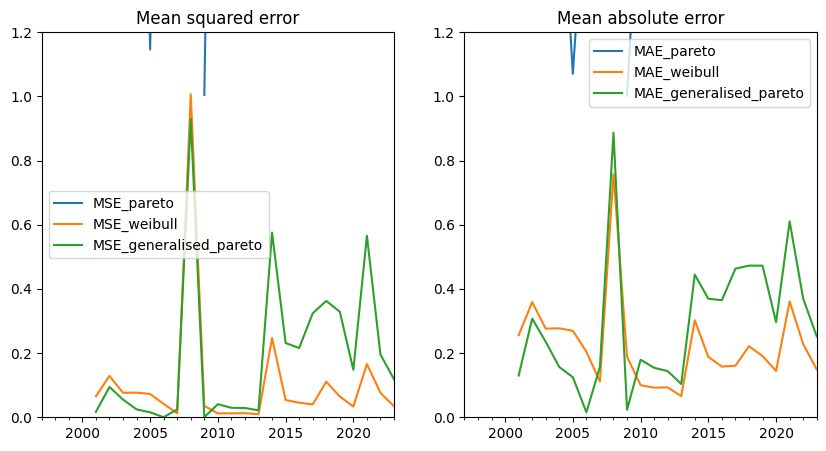

In [19]:
# plot the MSEs and MAEs over time
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
MSE_df.plot(ax=ax[0], title='Mean squared error')
MAE_df.plot(ax=ax[1], title='Mean absolute error')
# change the y lim
ax[0].set_ylim(0, 1.2)
ax[1].set_ylim(0, 1.2)
plt.show()


## Conclusion

- Generally, both Weibull and GPD fit the data better
- The GPD fit is slightly better (in terms of distribution)
- The Weibull distribution yields better mean wealth predictions than GPD